In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from rnn import RNNNet
from dataset import StimuliDataset

In [2]:
#loads the model
hidden_size = 128
input_size = 13
output_size = 6
dt = 0.1
tau = 100
batch_size = 1
model_path = './model.pt'
num_trials = 500
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, tau=tau)
net.load_state_dict(torch.load(model_path))
# Check if a GPU is available
device = torch.device("cpu")

# Move the network to the device
net = net.to(device)

print(num_trials)
dataset = StimuliDataset(num_trials)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

500


In [49]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {}
diff_shape={} 
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * 3, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue                
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            if (attended_info[i]>0):
                if (torch.argmax(output, dim=1).item() == labels.item()):
                    diff_shape[i] = 1
                else:
                    diff_shape[i] = 0
                    
            
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:3][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")

/tmp/ipykernel_20028/2645972498.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


In [50]:
attended_trials_stimulus = []
attended_trials_decision = []
unattended_trials_stimulus = []
unattended_trials_decision = []
for i in range(len(attended_info)):
        if (attended_info[i] > 0):
                attended_trials_stimulus.append(stimulus_activity_dict[i])
                attended_trials_decision.append(decision_activity_dict[i])
        else:
                unattended_trials_stimulus.append(stimulus_activity_dict[i])
                unattended_trials_decision.append(decision_activity_dict[i])
                
                
attended_trials_num = len(attended_trials_stimulus)
unattended_trials_num = len(unattended_trials_stimulus)

attended_trials_stimulus = np.concatenate(list(attended_trials_stimulus[i] for i in range(attended_trials_num)), axis=0)
attended_trials_decision = np.concatenate(list(attended_trials_decision[i] for i in range(attended_trials_num)), axis=0)
unattended_trials_stimulus = np.concatenate(list(unattended_trials_stimulus[i] for i in range(unattended_trials_num)), axis=0)
unattended_trials_decision = np.concatenate(list(unattended_trials_decision[i] for i in range(unattended_trials_num)), axis=0)

In [51]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca_attended_stimulus = PCA(n_components=6)
pca_attended_stimulus.fit(attended_trials_stimulus)

pca_unattended_stimulus = PCA(n_components=6)
pca_unattended_stimulus.fit(unattended_trials_stimulus)

PCA(n_components=6)

{1: 1, 3: 1, 4: 1, 7: 1, 8: 1, 13: 1, 14: 1, 18: 1, 22: 1, 23: 1, 26: 1, 29: 1, 30: 1, 31: 1, 32: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 44: 1, 46: 1, 47: 1, 53: 1, 55: 1, 58: 1, 60: 1, 61: 1, 62: 1, 63: 1, 68: 1, 69: 1, 71: 1, 75: 1, 78: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 88: 1, 89: 1, 90: 1, 91: 1, 94: 1, 95: 1, 97: 1, 101: 1, 102: 1, 103: 1, 105: 1, 108: 1, 109: 1, 110: 1, 111: 1, 113: 1, 115: 1, 117: 1, 119: 1, 121: 1, 122: 1, 126: 1, 130: 1, 132: 1, 136: 1, 139: 1, 141: 1, 142: 1, 143: 1, 145: 1, 147: 1, 148: 1, 153: 1, 155: 1, 156: 1, 157: 1, 159: 1, 163: 1, 164: 1, 167: 1, 168: 1, 171: 1, 173: 1, 174: 1, 175: 1, 176: 1, 178: 1, 179: 1, 181: 1, 182: 1, 183: 1, 184: 1, 186: 1, 190: 1, 192: 1, 193: 1, 194: 1, 198: 1, 199: 1, 204: 1, 206: 1, 207: 1, 209: 1, 210: 1, 212: 1, 213: 1, 214: 1, 215: 1, 217: 1, 218: 1, 219: 1, 220: 1, 223: 1, 224: 1, 228: 1, 229: 1, 230: 1, 231: 1, 233: 1, 246: 1, 250: 1, 251: 1, 253: 1, 254: 1, 256: 1, 259: 1, 260: 1, 261: 1, 262: 1, 264: 1, 265: 1, 268

Text(0, 0.5, 'PC 1')

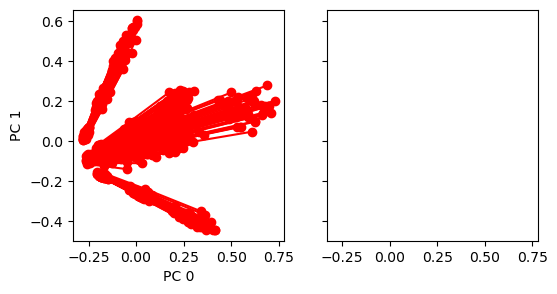

In [52]:
#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
print(diff_shape)
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        color = 'red' if diff_shape[i] > 0 else 'blue'
        attended_count+=1

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

In [60]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {} 
diff_object={}  #only records attended trials
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * 3, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue                
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            if (attended_info[i]>0):
                    diff_object[i] = np.where(inputs[0][0][:] == 1.0)[0][0]-6            
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:3][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")

/tmp/ipykernel_20028/2558479565.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


Text(0, 0.5, 'PC 1')

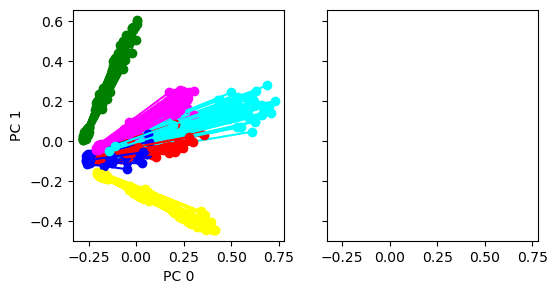

In [62]:
#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

Text(0, 0.5, 'PC 2')

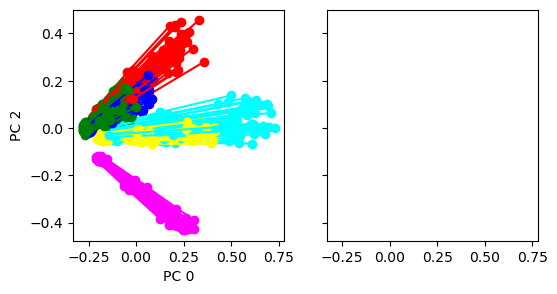

In [65]:
#same as above but using diff PC's

#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 2')

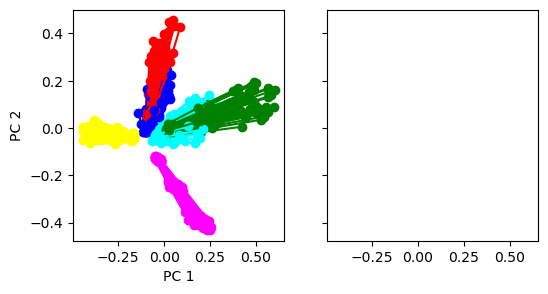

In [66]:
#same as above but using diff PC's

#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 1], attended_stimulus_activity_pc[:, 2], 'o-',color = color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

Text(0, 0.5, 'PC 4')

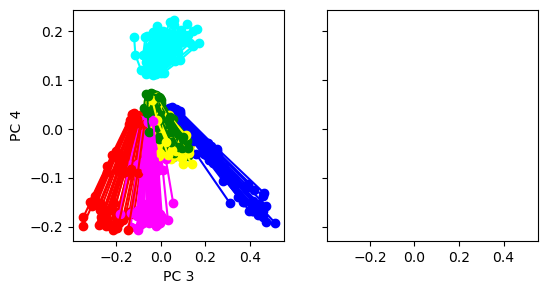

In [67]:
#same as above but using diff PC's

#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 3], attended_stimulus_activity_pc[:, 4], 'o-',color = color)

ax1.set_xlabel('PC 3')
ax1.set_ylabel('PC 4')

Text(0, 0.5, 'PC 5')

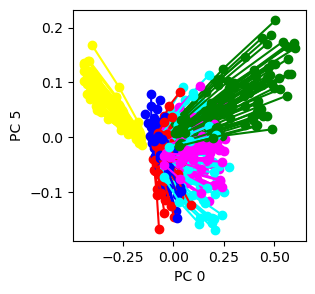

In [73]:
#same as above but using diff PC's

#pca'ed using attended (stimulus) trials, projecting attended trials onto attended pca space
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, figsize=(3, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 1], attended_stimulus_activity_pc[:, 5], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 5')

Text(0, 0.5, 'PC 1')

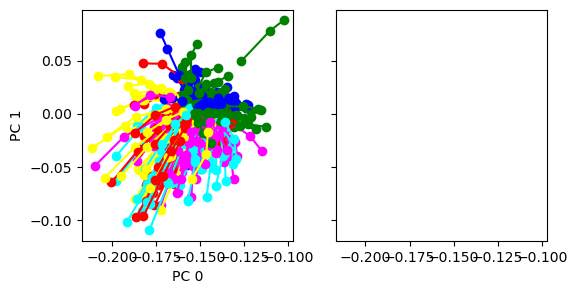

In [63]:
#projecting attended trials onto unattended pca space
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    if (attended_info[i] > 0):
        attended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
        if (diff_object[i] == 0):
            color = 'red' 
        if (diff_object[i] == 1):
            color = 'green' 
        if (diff_object[i] == 2):
            color = 'blue' 
        if (diff_object[i] == 3):
            color = 'cyan' 
        if (diff_object[i] == 4):
            color = 'magenta' 
        if (diff_object[i] == 5):
            color = 'yellow' 

        _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')